<a href="https://colab.research.google.com/github/changdaeoh/HandsOn_DL/blob/main/exercise/Building_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [63]:
def learning_curve(history):
    hist = history.history
    train_loss, val_loss = hist["loss"], hist["val_loss"]

    fig = plt.figure(figsize = (6, 6))
    plt.style.use("seaborn-dark")

    plt.plot(range(len(train_loss)), train_loss, label = "train_loss")
    plt.plot(range(len(train_loss)), val_loss, label = "val_loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.tight_layout()
    plt.show()

# 1. build a simple autoencoder

In [48]:
(x_train, _), (x_test, _) = mnist.load_data()

# scaling
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# flatten
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
?np.prod() # input된 array의 원소들을 곱

In [8]:
encoding_dim = 32 

input_img = keras.Input(shape=(784,))
# encoded : the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# decoded : the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# 전체 모델
autoencoder = keras.Model(input_img, decoded)

# 인코더 : 입력을 encoded representation으로 매핑
encoder = keras.Model(input_img, encoded)

# 디코더 : 인코딩된 표현을 원본 입력의 reconstruct로 매핑
encoded_input = keras.Input(shape = (encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# LOSS로 BCE를 사용 - target으로 x_train(0~1 scaled) 자기자신을 사용 -> 얼마나 비슷한지 비교
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 0)

In [13]:
# Encode and decode the test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [42]:
def plotting(arr1, arr2, n = 10): 
    
    indices = np.random.randint(len(arr1), size=n)
    images1 = arr1[indices, :]
    images2 = arr2[indices, :]

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images1[i].reshape(28, 28))         # 784 to (28, 289)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(images2[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

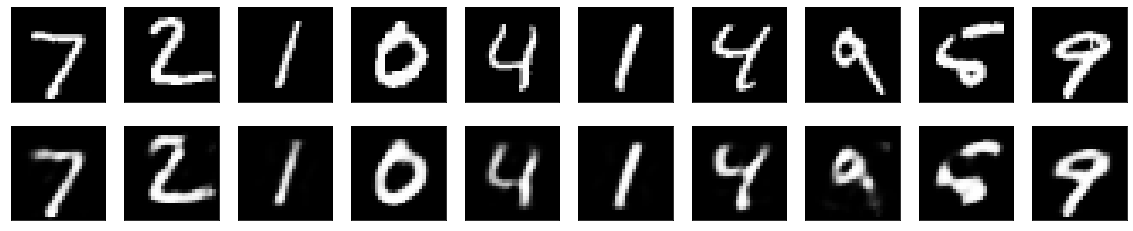

In [14]:
plotting(arr1 = x_test, arr2 = decoded_imgs)

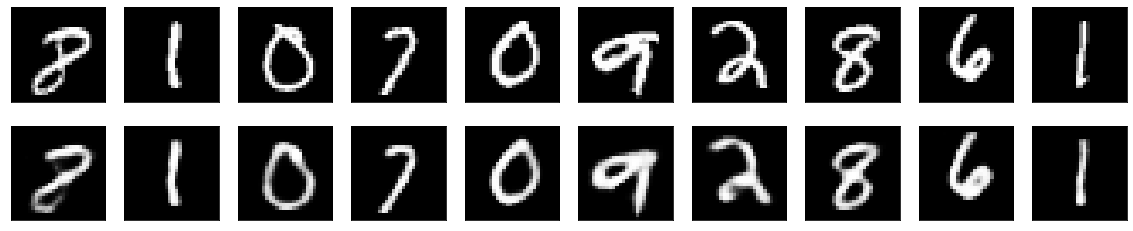

In [49]:
# deeper
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 0)

decoded_imgs = autoencoder.predict(x_test)
plotting(arr1 = x_test, arr2 = decoded_imgs)

# 2. Adding a sparsity constraint on the encoded representation

In [15]:
from keras import regularizers

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 0)

# Encode and decode the test set
decoded_imgs = autoencoder.predict(x_test)

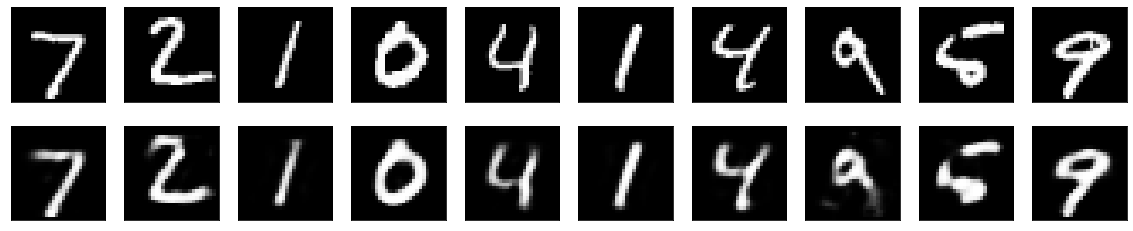

In [19]:
plotting(arr1 = x_test, arr2 = decoded_imgs)

# 3. Convolutional Autoencoder

In [22]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [50]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(x_train)
test_data = preprocess(x_test)

In [25]:
?layers.MaxPooling2D

In [52]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [53]:
hist1 = autoencoder.fit(train_data, train_data,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data),
                verbose = 0)

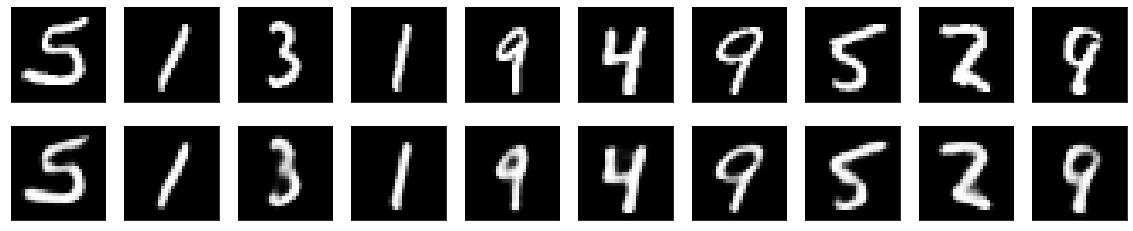

In [43]:
decoded_imgs = autoencoder.predict(test_data)
plotting(test_data, decoded_imgs)

# 4. image denoising

In [51]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

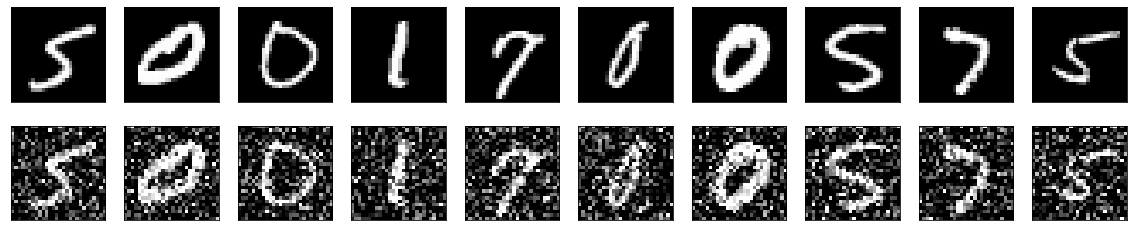

In [46]:
plotting(train_data, noisy_train_data)

In [71]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
# autoencoder.summary()

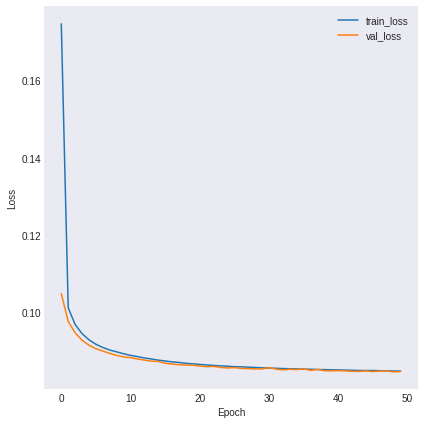

In [72]:
hist = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
    verbose = 0
)

learning_curve(hist)

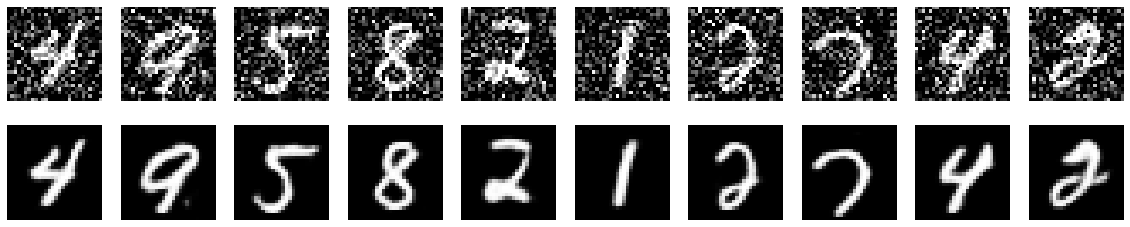

In [70]:
predictions = autoencoder.predict(noisy_test_data)
plotting(noisy_test_data, predictions)